In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from IPython.display import clear_output
eps = 1e-5

2025-03-04 09:12:45.063535: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 09:12:45.470936: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 09:12:46.092850: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [90]:
# Load the Fashion-MNIST data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)      
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)


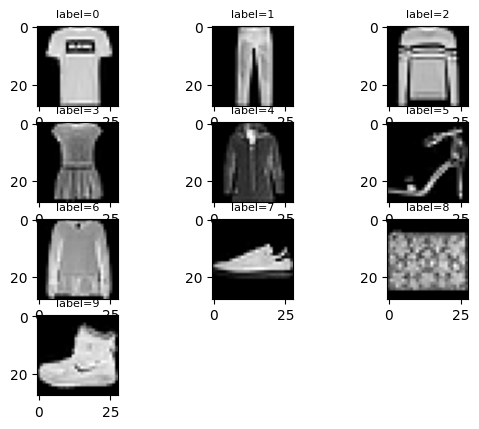

In [91]:
# Getting the unique labels and one entry from each
labels = set(y_train)
sample = {ind: np.where(y_train == ind)[0][0] for ind in labels}

# Plotting one image from each label
for i in range(10):
    plt.subplot(4,3,i+1)
    plt.imshow(x_train[sample[i]], cmap='gray')
    plt.title(f"label={i}", fontsize=8)

plt.show()


In [92]:
def one_hot_encode(y):
    one_hot_vectors = []
    for i in y:
        vec = np.zeros((10,))
        vec[i] = 1
        one_hot_vectors.append(vec)
    return np.array(one_hot_vectors)

In [93]:
# getting validation data
x_train, x_valid = x_train[:50000], x_train[50000:]
y_train, y_valid = y_train[:50000], y_train[50000:]


# reshaping the data
x_train = x_train.reshape(x_train.shape[0], 28*28)
x_train = x_train - x_train.mean()/x_train.std()
x_valid = x_valid.reshape(x_valid.shape[0], 28*28)
x_valid = x_valid/x_valid.sum()
x_test = x_test.reshape(x_test.shape[0], 28*28)
x_test = x_test/x_test.sum()

print('x_train shape:', x_train.shape)
print('x_valid shape:', x_valid.shape)
print('x_test shape:', x_test.shape)

# Converting the labels to one-hot encoding
y_train = one_hot_encode(y_train)
y_valid = one_hot_encode(y_valid)
y_test = one_hot_encode(y_test)

print('y_train shape:', y_train.shape)
print('y_valid shape:', y_valid.shape)
print('y_test shape:', y_test.shape)

x_train shape: (50000, 784)
x_valid shape: (10000, 784)
x_test shape: (10000, 784)
y_train shape: (50000, 10)
y_valid shape: (10000, 10)
y_test shape: (10000, 10)


In [117]:
# Activation functions
#class Activation():

#@classmethod
def sigmoid(x):
    return 1/(1+np.exp(-x) + eps)
#@classmethod
def softmax(x):
    max_x = np.max(x, axis=1, keepdims=True)
    x = x - max_x
    return np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True)
#@classmethod
def relu(x):
    return np.maximum(0, x)
#@classmethod
def tanh(x):
    return np.tanh(x)


# Layer class
class Layer():
    def __init__(self, name, input_size, n_units, activation=None):
        self.n = name
        self.weights = np.random.randn(n_units, input_size)
        self.bias = np.random.randn(n_units)
        self.g = activation
        self.grad_w = None
        self.grad_b = None
        self.a = None   # Preactivatiuon
        self.h = None   # Activation

    def __call__(self, input):

        hidden = input @ self.weights.T + self.bias
        self.preact = hidden
        self.act = self.activation(hidden)
        return self.act
    
    def activation(self, z):
        if self.g == 'sigmoid':
            return sigmoid(z)
        elif self.g == 'softmax':
            return softmax(z)
        elif self.g == 'relu':
            return relu(z)
        elif self.g == 'tanh':
            return tanh(z)
        elif self.g == None:
            return z
            



In [131]:
# Neural Network class
class NeuralNet():
    def __init__(self, input_size, n_units: list, loss:str, optimizer=None):
        self.n_layers = len(n_units)
        self.n_units = n_units
        self.input_size = input_size
        self.output_size = n_units[-1]
        self.layers = self._network()
        self.loss_fn = loss
        self.loss = 0
        self.optimizer = optimizer
        self.optimizer.set_model(self)

        
    def _network(self):
        layers = []
        for i in range(self.n_layers):
            if i==0:
                layers.append(Layer(i, self.input_size, self.n_units[i], activation="sigmoid"))
            elif i < self.n_layers-1:
                layers.append(Layer(i, self.n_units[i-1], self.n_units[i], activation="sigmoid"))
            else:
                layers.append(Layer(i, self.n_units[i-1], self.n_units[i], activation="softmax"))
            
        return layers
    
    def get_weights(self):
        return [layer.weights for layer in self.layers]
    
    def get_biases(self):
        return [layer.bias for layer in self.layers]
    
    def backpropogation(self, x, y, output):
        self.optimizer.backprop(x, y, output)

        
    def __call__(self, x, y):
        for layer in self.layers:
            x = layer(x)
        
        self.loss = self.loss_fn(x, y)
        return x

In [132]:
# Loss function
class Loss():
    def __init__(self, loss_fn = 'cross_entropy'):
        self.loss_fn = loss_fn

    def __call__(self, y_true, y_pred):
        if self.loss_fn == 'cross_entropy':
            return np.mean(self.cross_entropy(y_true, y_pred))
        elif self.loss_fn == 'mse':
            return np.mean(self.mse(y_true, y_pred))
        
    def cross_entropy(self, y_true, y_pred):
        return -np.log(np.sum(y_true*y_pred, axis=1))
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true-y_pred)**2)

In [133]:
def batch_data(x, y, batch_size):
    batches = []
    for i in range(0, x.shape[0], batch_size):
        batches.append((x[i:i+batch_size], y[i:i+batch_size]))
    return batches

In [126]:
def compute_grads(model, W1, W2, W3, W4, x, y, output):    
    a4 = model.layers[3].preact
    a3 = model.layers[2].preact.reshape(4, 32, 1)
    a2 = model.layers[1].preact.reshape(4, 32, 1)
    a1 = model.layers[0].preact.reshape(4, 32, 1)

    h1 = model.layers[0].act.reshape(4, 32, 1)
    h2 = model.layers[1].act.reshape(4, 32, 1)
    h3 = model.layers[2].act.reshape(4, 32, 1)
    h4 = model.layers[3].act.reshape(4, 10, 1)


    #grad_h4 = grad_yhat(y_train[:10], out[:10])
    grad_a4 = grad_output(y, output).reshape(4, 10, 1)

    grad_h3 = grad_hidden(W4, grad_a4)
    grad_a3 = grad_preact(grad_h3 ,a3, 'sigmoid')

    grad_h2 = grad_hidden(W3, grad_a3)
    grad_a2 = grad_preact(grad_h2, a2, 'sigmoid')

    grad_h1 = grad_hidden(W2, grad_a2)
    grad_a1 = grad_preact(grad_h1, a1, 'sigmoid')


    grad_w1 = np.sum(grad_weights(grad_a1, x.reshape(4, 784, 1)), axis = 0)
    grad_b1 = np.sum(grad_bias(grad_a1), axis=0)
    grad_w2 = np.sum(grad_weights(grad_a2, h1), axis = 0)
    grad_b2 = np.sum(grad_bias(grad_a2), axis=0)
    grad_w3 = np.sum(grad_weights(grad_a3, h2), axis = 0)
    grad_b3 = np.sum(grad_bias(grad_a3), axis=0)
    grad_w4 = np.sum(grad_weights(grad_a4, h3), axis = 0)
    grad_b4 = np.sum(grad_bias(grad_a4), axis=0)

    return grad_w1, grad_w2, grad_w3, grad_w4, grad_b1, grad_b2, grad_b3, grad_b4


In [134]:
batch_size = 4
loss = Loss(loss_fn='cross_entropy')
optimizer = GradientDescent(lr=0.01)
model = NeuralNet(x_train.shape[1], [32, 32, 32, 10], loss, optimizer)
dataloader = batch_data(x_train, y_train, batch_size)
losses = []
"""W4 = model.layers[3].weights
W3 = model.layers[2].weights
W2 = model.layers[1].weights
W1 = model.layers[0].weights
b1 = model.layers[0].bias
b2 = model.layers[1].bias
b3 = model.layers[2].bias
b4 = model.layers[3].bias
lr = 0.0001"""
for epoch in range(10):
    i=0
    print(f"Epoch: {epoch}")
    batch_loss = []
    for x,y in dataloader:
        output = model(x,y)
        loss = model.loss
        i+=1
        if i%1000 == 0:
            print(f"batch {i} loss: {loss}")
        batch_loss.append(loss)
        
        model.backpropogation(x, y, output)
        
        """     
        grad_w1, grad_w2, grad_w3, grad_w4, grad_b1, grad_b2, grad_b3, grad_b4 = compute_grads(model, W1, W2, W3, W4, x, y, output)
        # Clip gradients
        grad_w1 = clip_gradients(grad_w1, threshold)
        grad_w2 = clip_gradients(grad_w2, threshold)
        grad_w3 = clip_gradients(grad_w3, threshold)
        grad_w4 = clip_gradients(grad_w4, threshold)
        grad_b1 = clip_gradients(grad_b1, threshold)
        grad_b2 = clip_gradients(grad_b2, threshold)
        grad_b3 = clip_gradients(grad_b3, threshold)
        grad_b4 = clip_gradients(grad_b4, threshold)

        # Check for NaNs
        check_for_nans(grad_w1)
        check_for_nans(grad_w2)
        check_for_nans(grad_w3)
        check_for_nans(grad_w4)
        check_for_nans(grad_b1)
        check_for_nans(grad_b2)
        check_for_nans(grad_b3)
        check_for_nans(grad_b4)



        W1 = W1 - lr*grad_w1
        b1 = b1 - lr*grad_b1.squeeze()
        W2 = W2 - lr*grad_w2
        b2 = b2 - lr*grad_b2.squeeze()
        W3 = W3 - lr*grad_w3
        b3 = b3 - lr*grad_b3.squeeze()
        W4 = W4 - lr*grad_w4
        b4 = b4 - lr*grad_b4.squeeze()
        model.layers[0].weights = W1
        model.layers[0].bias = b1
        model.layers[1].weights = W2
        model.layers[1].bias = b2
        model.layers[2].weights = W3
        model.layers[2].bias = b3
        model.layers[3].weights = W4
        model.layers[3].bias = b4
"""       

    clear_output(True)
    print(f"average epoch loss: {np.mean(batch_loss)}")
    losses.append(np.mean(batch_loss))


average epoch loss: 2.157080601194341


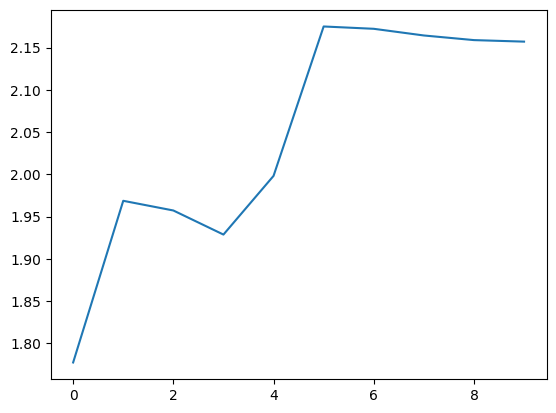

In [135]:
plt.plot(losses)

In [113]:
class GradientDescent():
    def __init__(self, optimizer = 'sgd', lr = 0.01, clipping_threshold = 1e5):
        self.model = model
        self.optimizer = optimizer
        self.lr = lr
        self.threshold = clipping_threshold
    
    def clip_gradients(self, gradients):
        return np.clip(gradients, -self.threshold, self.threshold)

    def clip_all_gradients(self):
        for layer in self.model.layers:
            layer.grad_w = self.clip_gradients(layer.grad_w)
            layer.grad_b = self.clip_gradients(layer.grad_b)
    
    
    def check_for_nans(self, array):
        if np.isnan(array).any():
            raise ValueError("NaN detected in array")


    def set_model(self, model):
        self.model = model

    def backprop(self, x, y, output):
        self.compute_grads(x, y, output)
        self.clip_all_gradients()
        self.update_weights()
        
         
    def update_weights(self):
        for layer in model.layers:
            layer.weights = layer.weights - self.lr*layer.grad_w
            layer.bias = layer.bias - self.lr*layer.grad_b.squeeze() 
        

    def compute_grads(self, x, y, output):    
        for layer in self.model.layers[::-1]:
            
            # Gradients wrt to the output layer, preactivation, activation, weights and biases
            if layer.n == self.model.n_layers - 1:
                layer.grad_a = self.grad_output(y, output).reshape(batch_size, self.model.output_size, 1)
                layer.grad_w = np.sum(self.grad_weights(layer.grad_a, self.model.layers[layer.n - 1].act.reshape(batch_size, self.model.n_units[0], 1)), axis = 0)
                layer.grad_b = np.sum(self.grad_bias(layer.grad_a), axis=0)
            
            # Gradients wrt to the hidden layers, preactivation, activation, weights and biases
            else:
                layer.grad_h = self.grad_hidden(self.model.layers[layer.n + 1].weights, self.model.layers[layer.n + 1].grad_a)
                layer.grad_a = self.grad_preact(layer.grad_h, self.model.layers[layer.n].preact.reshape(batch_size, self.model.n_units[0], 1), 'relu')
            
           
                if layer.n == 0:
                    layer.grad_w= np.sum(self.grad_weights(layer.grad_a, x.reshape(batch_size, self.model.input_size, 1)), axis = 0)    # Gradients wrt to the input layer, preactivation, activation, weights and biases
                else:
                   layer.grad_w = np.sum(self.grad_weights(layer.grad_a, self.model.layers[layer.n - 1].act.reshape(batch_size, self.model.n_units[0], 1)), axis = 0)
                layer.grad_b = np.sum(self.grad_bias(layer.grad_a), axis=0)
        

    def grad_yhat(self, y_true, y_pred, loss = 'cross_entropy'):
        if loss == 'cross_entropy':
            y_grad = np.sum(y_true * y_pred, axis=1)
        #elif loss == 'mse':
        #    y_grad = y_pred
        return -(y_true/y_grad[:, np.newaxis])


    def grad_output(self, y_true, y_pred):
        return -(y_true-y_pred)


    def grad_hidden(self, W, grad_next_preact):
        return W.T @ grad_next_preact


    def grad_preact(self, grad_act, act, activation):
        if activation == 'sigmoid':    # for sigmoid
            return grad_act*act*(1-act)
        elif activation == 'relu':    # for relu 
            return grad_act*(act>0)
        elif activation == 'tanh':    # for tanh
            return grad_act*(1-act**2)


    def grad_weights(self, grad_preact, input):
        return grad_preact @ input.transpose(0, 2, 1) 


    def grad_bias(self, grad_preact):
        return grad_preact

In [69]:
def grad_yhat(y_true, y_pred, loss = 'cross_entropy'):
    if loss == 'cross_entropy':
        y_grad = np.sum(y_true * y_pred, axis=1)
    #elif loss == 'mse':
    #    y_grad = y_pred
    return -(y_true/y_grad[:, np.newaxis])


def grad_output(y_true, y_pred):
    return -(y_true-y_pred)


def grad_hidden(W, grad_next_preact):
    return W.T @ grad_next_preact


def grad_preact(grad_act, act, activation):
    if activation == 'sigmoid':    # for sigmoid
        return grad_act*act*(1-act)
    elif activation == 'relu':    # for relu 
        return grad_act*(act>0)
    elif activation == 'tanh':    # for tanh
        return grad_act*(1-act**2)


def grad_weights(grad_preact, input):
    return grad_preact @ input.transpose(0, 2, 1) 


def grad_bias(grad_preact):
    return grad_preact

In [74]:
grad_a = {}
grad_h = {}
grad_w = {}
grad_b = {}
for layer in model.layers[::-1]:
    # Gradients wrt to the output layer, preactivation, activation, weights and biases
    if layer.n == model.n_layers - 1:
        layer.grad_a = grad_output(y, output).reshape(batch_size, model.output_size, 1)
        layer.grad_w = np.sum(grad_weights(layer.grad_a, model.layers[layer.n - 1].act.reshape(batch_size, model.n_units[0], 1)), axis = 0)
        layer.grad_b = np.sum(grad_bias(layer.grad_a), axis=0)
    
    # Gradients wrt to the hidden layers, preactivation, activation, weights and biases
    else:
        layer.grad_h = grad_hidden(model.layers[layer.n + 1].weights, model.layers[layer.n + 1].grad_a)
        layer.grad_a = grad_preact(layer.grad_h, model.layers[layer.n].preact.reshape(batch_size, model.n_units[0], 1), 'relu')
    
    # Gradients wrt to the input layer, preactivation, activation, weights and biases
        if layer.n == 0:
            grad_w[layer.n]= np.sum(grad_weights(layer.grad_a, x.reshape(batch_size, model.input_size, 1)), axis = 0)
        else:
            grad_w[layer.n] = np.sum(grad_weights(layer.grad_a, model.layers[layer.n - 1].act.reshape(batch_size, model.n_units[0], 1)), axis = 0)
        grad_b[layer.n] = np.sum(grad_bias(layer.grad_a), axis=0)
    
    

{}

In [ ]:
#TODO Generalize for n layers, m units per layer
#TODO Other gradient descent algorithms